## Домашнее здание №2 / Link Prediction

### Торунова Анастасия / 394

----
План выполнения домашнего задания:

1. Краткий обзор исходных данных
2. Генерация дополнительных данных
3. Создание матрицы признаков для ребер
4. Настройка модели и валидация качества модели
5. Отправка результатов в контест на Kaggle

----

В данном домашнем задании вам предстоит построить классификатор, который бы предсказывал наличие или отсутствие ребра в графе между двумя вершинами. Никакой дополнительной информации о вершинах, кроме ее соседей нет, поэтому вам придется создавать вектор признаков для каждой пары вершин на основе топологии графа.

Вершины графа - товары интернет магазина, наличие ребра символизирует высокую частоту совместной покупки данных товаров вместе. Например, если в нашем графе присутствую вершины молоко и хлеб и данные товары часто покупаются вместе, то между данными вершинами будет ребро. Если в нашем графе есть вершины молоко и кроссовки, то между данными вершинами ребра не будет. 

В данном датасете уровень относительной частоты, по которому решается есть ребро между вершинами или его нет был определен за нас. Сам датасет был получен краулингом сайта Amazon.com в марте 2003 года, парсилась секция "Люди которые купили данный продукт, также приобретали это..."

Мотивация данного задания: Расширить список блока рекомендаций, за счет товаров которые с высокой вероятность могут оказаться в одной корзине покупателя.

----
Для создания модели и работы с данными мы будем использовать пакет GraphLab, структуры данных SFrame и SGraph идеально подходят для работы с графами. Распределенное хранение данных и применение функций для расчета метрик отдельных вершин сильно облегчают работу с графом.

Библиотека платная, но лицензия для академических целей получается в течение 5 минут, чтобы установить пакет следуйте шагам на сайте - https://turi.com/download/academic.html

----

Описание файлов:

1. the_graph.csv - файл содержащий ребра графа, две колонки: src,dst 
2. suspicions.csv - файл с ребрами, графа. Для данных ребер неизвестно присутствует ли оно в графе или нет.

Описание целевой метрики - в качестве целевой метрики будем использовать ROC AUC http://mlwiki.org/index.php/ROC_Analysis

----

In [11]:
import graphlab as gl
import numpy as np
import pandas as pd
from collections import defaultdict, deque
import matplotlib.pyplot as plt
% matplotlib inline

gl.canvas.set_target('ipynb')

### 1. Краткий обзор исходных данных - 10 Баллов

Загрузим данные, найдем ряд базовых статистик:

1. Количество вершин и ребер
2. Распределение степеней вершин графа (График log - log)
3. Плотность графа
4. Диаметр графа
5. Количество треугольников в графе
6. Краткие выводы о данных.
7. БОНУСЫ - сделайте красивую визулизацию или расчет дополнительных метрик с выводами и вы получите дополнительные баллы за задание

In [12]:
edges = gl.SFrame.read_csv('the_graph.csv', delimiter=',', verbose=False)

In [13]:
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

1. Количество вершин и ребер

In [14]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 1384871


Выполните пункты 2 - 6. В пункте 6 напишите краткие выводы.

2.Распределение степеней вершин графа

In [15]:
vertex_degrees = defaultdict(int)
for idx, edge in enumerate(edges):
    if idx % 1000 == 0:
        print(idx)
    vertex_degrees[edge['src']] += 1
    vertex_degrees[edge['dst']] += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


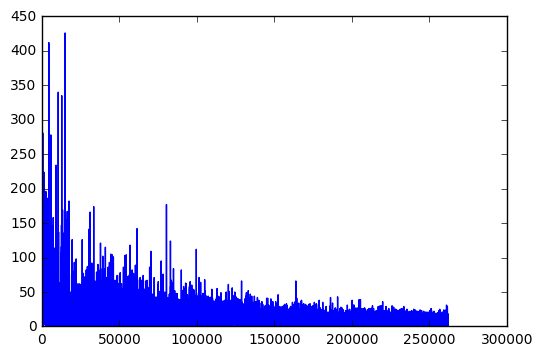

In [16]:
items = np.array(vertex_degrees.items())
plt.plot(items[:, 0], items[:, 1])
plt.show()

3.Плотность графа

In [17]:
e = vert_edgs['num_edges']
v = vert_edgs['num_vertices']
density = 2 * e / float((v * (v - 1)))
print('Density: {}'.format(density))

Density: 4.03153541186e-05


4.Диаметр графа

In [18]:
def bfs(root, adjacent_vertices):
    queue = deque()
    queue.append(root)
    distances = {root: 0}
    print 'kek'
    counter = 0
    while queue:
        if counter % 1000 == 0:
            print counter
        curr_vertex = queue.pop()
        for adj_vertex in adjacent_vertices[curr_vertex]:  # edges[edges['src'] == curr_vertex]['dst']:
            if adj_vertex not in distances.keys():
                queue.append(adj_vertex)
                distances[adj_vertex] = distances[curr_vertex] + 1
        counter += 1
    return distances

In [19]:
adjacent_vertices = defaultdict(list)
print 'Building adjacent vertices dict...', 
for edge in edges:
    adjacent_vertices[edge['src']].append(edge['dst'])
    adjacent_vertices[edge['dst']].append(edge['src'])
print 'Done'
distances_1 = bfs(0, adjacent_vertices) 

Building adjacent vertices dict... Done


KeyboardInterrupt: 

In [10]:
len(distances.items()) == vert_edgs['num_vertices']

NameError: name 'distances' is not defined

----
### 2. Генерация дополнительных данных - 20 Баллов

Перед нами стоит задача создания модели классификации, которая в дальнейшем будет использоваться для повышения разнообразия блока рекомендаций. Для большинства моделей классификации требуется минимум 2 класса объектов - негативный и позитивный. Но у нас есть только граф, ребра которые в нем присутствуют это позитивные примеры. Получается, что у нас нет негативных примеров. 

Ответьте на 3 вопроса:

1. Можем ли мы сами создать негативные примеры? Граф это описание связей между вершинами, если мы будем случайным образом выбирать две вершины и считать, что это ребро - негативный пример, имеет ли это смысл?
2. Если мы решим сгенерировать негативные примеры, как должна быть устроена процедура генерации, чтобы обобщаяющая способность модели была наилучшей?
3. Как зависит обобщающая способность модели от негативных примеров, которые мы ей покажем?

------
Создадим класс отрицательных примеров, сгенерировав его самым простым образом: берем две вершины, если ребро между ними отсутствует в графе, то это отрицательный пример.

1. Попробуйте улучшить генерацию отрицательных примеров

In [6]:
# read in existing edges
graph_file = open('the_graph.csv')
graph_file.readline() # first line is column names
existing_edges = set()

for x in graph_file:
    start, end = x.split(',')
    start, end = int(start), int(end)
    existing_edges.add((start, end))
    
print len(existing_edges)

1384871


In [7]:
# generating negative examples, so that class balance is 50/50 
generated_nonexisting_edges = []
counter = 0
while True:
    start = np.random.randint(0, vert_edgs['num_vertices'])
    end = np.random.randint(0, vert_edgs['num_vertices'])
    
    if (start != end) & ((start, end) not in existing_edges):
        generated_nonexisting_edges.append([start, end, 0])
        
    counter += 1
    if counter == vert_edgs['num_edges']:
        break

print len(generated_nonexisting_edges)

1384841


In [8]:
# create SFrame with negative examples
generated_nonexisting_edges = pd.DataFrame(data=generated_nonexisting_edges, columns=['src', 'dst', 'class'])
generated_nonexisting_edges = gl.SFrame(data=generated_nonexisting_edges)

In [9]:
# add target function to the original dataset 
edges['class'] = [1]*edges.shape[0]

In [10]:
# add negative examples to the main data and shuffle
edges = edges.append(generated_nonexisting_edges)
edges = gl.cross_validation.shuffle(edges)

In [11]:
# update our graph g with fake edges
g = gl.SGraph().add_edges(edges, src_field='src', dst_field='dst')

In [12]:
vert_edgs = g.summary()

print 'Number of vertices = {0}'.format(vert_edgs['num_vertices'])
print 'Number of edges = {0}'.format(vert_edgs['num_edges'])

Number of vertices = 262111
Number of edges = 2769712


----
### 3. Создание матрицы признаков для ребер - 30 Баллов

Для создания модели классификации нам необходимы признаки, которые описывают каждое ребро. Вот базовый список того, что можно посчитать:

Для вершин:

1. Список и количество вершин, из которых ребра приходят в данную вершину
2. Список и количество вершин, в которые ребра приходят из данной вершины
3. Список и количество вершин связанных с данной вершиной
4. Список и количество вершин, которые связанны с данной вершиной как входящими, так и исходящими ребрами

Также можно добавить: вершины с которыми данная вершина образует треугольники, кластеризовать вершины и использовать кластер данной вершины и др.

Придумайте дополнительные интересные признаки для вершин и вы получите дополнительный балл за домашнюю работу!

In [13]:
all_vertices = g.get_vertices()
all_vertices.rename({"__id": "id"}) 
all_vertices.head(3)

id
5
7
8


In [14]:
# calculating each vertices in and out connections
out_vertices = edges.groupby("src", {"out_vertices": gl.aggregate.CONCAT("dst")})
out_vertices.rename({"src": "id"})

in_vertices = edges.groupby("dst", {"in_vertices": gl.aggregate.CONCAT("src")})
in_vertices.rename({"dst": "id"})
print 

In [15]:
# join in and out connections with all_vertices
all_vertices = all_vertices.join(out_vertices, on="id", how="outer")
all_vertices = all_vertices.join(in_vertices, on="id", how="outer")

# replace missing values with empty lists
all_vertices = all_vertices.fillna('in_vertices',[])
all_vertices = all_vertices.fillna('out_vertices',[])
all_vertices.head(3)

id,out_vertices,in_vertices
211023,"[125038, 233626, 181032,129442, 172885, 78851, ...","[209072, 233626, 130553,248527, 149114, 198886, ..."
79732,"[127247, 81407, 102671,79734, 75040, 83186, ...","[138065, 201679, 103248,83186, 162573, 55606, ..."
7899,"[7896, 159251, 205061,172020, 13587, 11624, ...","[8977, 27312, 6150,15258, 212028, 7898, ..."


Мы получили базовый набор данных - список входящих и исходящих вершин, для каждой вершины. Теперь найдем количества вершин для метрик 1 и 2. Метрики 3 и 4 вы посчитаете сами

In [16]:
# in_degree - number of users following each vertex
all_vertices['in_degree'] = all_vertices["in_vertices"].apply(lambda x: len(x) )

# out_degree - number of users each vertex is following
all_vertices['out_degree'] = all_vertices["out_vertices"].apply(lambda x: len(x) )

In [17]:
all_vertices.head(3)

id,out_vertices,in_vertices,in_degree,out_degree
211023,"[125038, 233626, 181032,129442, 172885, 78851, ...","[209072, 233626, 130553,248527, 149114, 198886, ...",10,14
79732,"[127247, 81407, 102671,79734, 75040, 83186, ...","[138065, 201679, 103248,83186, 162573, 55606, ...",15,8
7899,"[7896, 159251, 205061,172020, 13587, 11624, ...","[8977, 27312, 6150,15258, 212028, 7898, ...",12,10


Мы получили характеристики для каждой вершины графа. Так как у нас задача предсказания наличия ребра, мы должны составить описание каждого ребра, используя метрики вершин. После составления характеристик ребер, мы можем перейти к генерации свойств ребер, взяв за основу метрики вершин ребра. Пример метрик для ребер, которые мы можем найти:

1. Общие друзья вершин ребра
2. Общее количество друзей вершин ребра
3. Коэффициенты Жаккара, Пирсона, Адамик - Адара, косинусная мера

Данные метрики находятся для каждого списка вершин, пунктов 1 - 4

In [18]:
all_vertices

id,out_vertices,in_vertices,in_degree,out_degree
211023,"[125038, 233626, 181032,129442, 172885, 78851, ...","[209072, 233626, 130553,248527, 149114, 198886, ...",10,14
79732,"[127247, 81407, 102671,79734, 75040, 83186, ...","[138065, 201679, 103248,83186, 162573, 55606, ...",15,8
7899,"[7896, 159251, 205061,172020, 13587, 11624, ...","[8977, 27312, 6150,15258, 212028, 7898, ...",12,10
25263,"[6965, 42350, 42349,19115, 6963, 6961, ...","[42349, 6965, 115573,169357, 261127, 157786, ...",14,9
87629,"[117259, 137137, 4221,117244, 105937, 6873, ...","[92901, 236889, 137136,211256, 183942, 150527, ...",25,10
43116,"[249682, 119313, 43113,8658, 133820, 131188, ...","[43117, 90294, 246688,43113, 78829, 50535, ...",17,13
144280,"[111931, 25249, 22436,248150, 154011, 83567, ...","[124943, 103880, 133530,152258, 4486, 152259] ...",6,14
238256,"[175756, 137742, 19746,242814, 232100, 19654, ...","[249606, 232100, 208524,45568, 135010, 94708, ...",7,12
62361,"[62676, 222504, 220681,128106, 62359, 188876, ...","[118990, 70917, 62359,38016, 148406, 70918, ...",23,14
5288,"[7373, 2769, 9421, 3077,219785, 173588, 227022, ...","[9420, 7375, 7373, 8712,5468, 9421, 1642, 74947, ...",14,8


In [19]:
edges = edges.join(all_vertices, on={"src": "id"}, how="right")
edges.rename({"in_vertices": "src_in_vertices", "out_vertices": "src_out_vertices",
                  "in_degree": "src_in_degree", "out_degree": "src_out_degree"
                 })

edges = edges.join(all_vertices, on={"dst": "id"}, how="right")
edges.rename({"in_vertices": "dst_in_vertices", "out_vertices": "dst_out_vertices",
                  "in_degree": "dst_in_degree", "out_degree": "dst_out_degree"})

edges.head(3)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	list
	src_in_vertices	list
	src_in_degree	int
	src_out_degree	int
	dst_out_vertices	list
	dst_in_vertices	list
	dst_in_degree	int
	dst_out_degree	int

Rows: 3

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 36624  | 235817 |   1   | [235817, 223305, 110712, 1... |
| 204849 | 213833 |   1   | [213833, 195444, 202324, 1... |
| 101355 | 48945  |   0   | [48945, 144461, 212543, 88... |
+--------+--------+-------+-------------------------------+
+-------------------------------+---------------+----------------+
|        src_in_vertices        | src_in_degree | src_out_degree |
+-------------------------------+---------------+----------------+
| [115542, 177553, 73059, 13... |       10      |       12       |
| [168430, 69415, 229202, 21... |       6       |       12       |
| [28229, 20714, 88679, 3372... |       5       |       12       |
+-------------------------------+---------------+----------------+
+-------------------------------+-------------------------------+---------------+
|        dst_out_vertices       |        dst_in_vertices        | dst_in_degree |
+-------------------------------+-------------------------------+---------------+
| [204449, 212887, 245085, 4... | [36624, 160445, 56532, 852... |       11      |
| [204415, 46244, 253182, 14... | [204849, 184918, 27826, 13... |       7       |
| [17610, 212149, 35485, 210... | [101355, 54363, 173623, 20... |       12      |
+-------------------------------+-------------------------------+---------------+
+----------------+
| dst_out_degree |
+----------------+
|       14       |
|       10       |
|       9        |
+----------------+
[3 rows x 11 columns]

Найдем пункт 1 - общих друзей для списков вершин из пункта 1. Пункты 2 и 3 вы посчитаете самостоятельно

In [20]:
def common_friends(u, v, u_neighbors, v_neighbors):
    u_neighbors = set(u_neighbors)
    if v in u_neighbors:
            u_neighbors.remove(v)

    v_neighbors = set(v_neighbors)
    if u in v_neighbors:
        v_neighbors.remove(u)
        
    return len(u_neighbors & v_neighbors)

In [21]:
edges['common_in_vertices'] = (edges[['src','dst', 'src_in_vertices', 'dst_in_vertices']]
                               .apply(lambda x: common_friends(x['src'], x['dst'],x['src_in_vertices'], x['dst_in_vertices'])))

Результатом пункта 3 является матрица признаков. Теперь мы готовы занятся настройкой моделей. Главная ваша задача в пункте 3 - подготовить как можно больше качественных признаков, которые могли бы использоваться для настройки модели машинного обучения.

----
### 4. Настройка модели и валидация качества модели - 20 Баллов

Исключим подозрительные ребра из рассмотрения, а затем разобьем датасет на 2 части, для обучения и проверки результатов. Настроим базовую модель классификации - логистическую регрессию.
Для улучшения качества модели вам предстоит выполнить следующие пункты:

1. Кросс - валидация для настройки гиперпараметров модели и регуляризации
2. Подбор модели машинного обучения (случайный лес, бустинг, нейронная сеть и т.д.)

In [22]:
susp = gl.SFrame.read_csv('suspicions.csv', delimiter=',', verbose=False)
print susp.shape

(299994, 3)


In [23]:
print edges.shape
edges = edges.join(susp, on=['src', 'dst'], how='left')
print edges.shape

(2769712, 12)
(2769712, 13)


In [24]:
clean_edges = edges[edges['edge_id'] == None]
susp_edges = edges[edges['edge_id'] != None]
print clean_edges.shape, susp_edges.shape

(2469718, 13) (299994, 13)


In [25]:
clean_edges.remove_column('edge_id')
print

In [26]:
clean_edges.head(3)

Columns:
	src	int
	dst	int
	class	int
	src_out_vertices	list
	src_in_vertices	list
	src_in_degree	int
	src_out_degree	int
	dst_out_vertices	list
	dst_in_vertices	list
	dst_in_degree	int
	dst_out_degree	int
	common_in_vertices	int

Rows: 3

Data:
+--------+--------+-------+-------------------------------+
|  src   |  dst   | class |        src_out_vertices       |
+--------+--------+-------+-------------------------------+
| 101355 | 48945  |   0   | [48945, 144461, 212543, 88... |
| 46194  | 185867 |   0   | [185867, 75042, 46193, 184... |
| 224536 | 206071 |   1   | [206071, 218520, 161, 1624... |
+--------+--------+-------+-------------------------------+
+-------------------------------+---------------+----------------+
|        src_in_vertices        | src_in_degree | src_out_degree |
+-------------------------------+---------------+----------------+
| [28229, 20714, 88679, 3372... |       5       |       12       |
| [31625, 191284, 73421, 108... |       13      |       7        |
| [206071, 189583, 226504, 2... |       8       |       12       |
+-------------------------------+---------------+----------------+
+-------------------------------+-------------------------------+---------------+
|        dst_out_vertices       |        dst_in_vertices        | dst_in_degree |
+-------------------------------+-------------------------------+---------------+
| [17610, 212149, 35485, 210... | [101355, 54363, 173623, 20... |       12      |
| [43157, 207398, 104024, 12... | [46194, 117192, 189506, 15... |       8       |
| [215731, 224536, 174005, 1... | [224536, 224537, 164200, 5... |       7       |
+-------------------------------+-------------------------------+---------------+
+----------------+--------------------+
| dst_out_degree | common_in_vertices |
+----------------+--------------------+
|       9        |         0          |
|       10       |         0          |
|       10       |         0          |
+----------------+--------------------+
[3 rows x 12 columns]

In [35]:
# split on train and test
test, train = clean_edges.random_split(0.2)

In [37]:
print test.shape, train.shape

(493512, 12) (1976206, 12)


In [38]:
# fit basic classification model - LR
model = gl.classifier.logistic_classifier.create(train, 
                                                 target="class", 
                                                 features=[x for x in clean_edges.column_names() if 'class' not in x])
results = model.evaluate(test)
print results

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Logistic regression:

--------------------------------------------------------

Number of examples          : 1877268

Number of classes           : 2

Number of feature columns   : 11

Number of unpacked features : 11

Number of coefficients    : 1048419

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 4        | 0.000000  | 10.419121    | 0.613062          | 0.603651            |

| 2         | 6        | 1.000000  | 17.326750    | 0.708492          | 0.638238            |

| 3         | 7        | 1.000000  | 21.600158    | 0.732180          | 0.642877            |

| 4         | 8        | 1.000000  | 25.620888    | 0.765225          | 0.644161            |

| 5         | 9        | 1.000000  | 29.689968    | 0.734595          | 0.646526            |

| 6         | 11       | 1.000000  | 36.544376    | 0.783402          | 0.663294            |

| 7         | 12       | 1.000000  | 40.992921    | 0.794094          | 0.664113            |

| 8         | 13       | 1.000000  | 46.060695    | 0.798794          | 0.663901            |

| 9         | 14       | 1.000000  | 50.565929    | 0.812954          | 0.662991            |

| 10        | 15       | 1.000000  | 54.652590    | 0.833784          | 0.672836            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

{'f1_score': 0.6222868163147988, 'auc': 0.7163561741742771, 'recall': 0.6185931408241703, 'precision': 0.6260248673152441, 'log_loss': 0.745825485545319, 'roc_curve': Columns:
	threshold	float
	fpr	float
	tpr	float
	p	int
	n	int

Rows: 100001

Data:
+-----------+----------------+----------------+--------+--------+
| threshold |      fpr       |      tpr       |   p    |   n    |
+-----------+----------------+----------------+--------+--------+
|    0.0    |      1.0       |      1.0       | 216994 | 276518 |
|   1e-05   | 0.999981917994 |      1.0       | 216994 | 276518 |
|   2e-05   | 0.99996745239  | 0.999995391578 | 216994 | 276518 |
|   3e-05   | 0.999949370385 | 0.999990783155 | 216994 | 276518 |
|   4e-05   | 0.999931288379 | 0.999990783155 | 216994 | 276518 |
|   5e-05   | 0.999920439176 | 0.999972349466 | 216994 | 276518 |
|   6e-05   | 0.999920439176 | 0.999972349466 | 216994 | 276518 |
|   7e-05   | 0.999913206374 | 0.999972349466 | 216994 | 276518 |
|   8e-05   | 0.99990597

Мы получили базовую модель с метриками: точность ~ 0.67, ROC AUC ~ 0.71. Ваша задача улучшить модель,  за счет добавления новых признаков вершин, ребер и аккуратного обучения выбранных моделей (настройки гиперпараметров и регуляризации).

----
### 5. Отправка результатов в контест на Kaggle - 20 Баллов


Завершая домашнюю работу, нам небходимо предсказать вероятности наличия ребер, для заданного списка ребер. Результат отправлется в контест на kaggle.com в формате: edge_id - probability

In [39]:
predicted = model.predict(susp_edges, output_type='probability')

In [40]:
susp_edges['probability'] = predicted

In [41]:
result = susp_edges['edge_id', 'probability']

In [42]:
result.save('result.csv', format='csv')

----

----
### Не модифицируйте данный код, он для проверки вашего ноутбука

In [35]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# %matplotlib inline

In [36]:
# labeled = pd.read_csv('labeled_suspicions.csv')
# print labeled.shape

# res = labeled.merge(result.to_dataframe(), on='edge_id', how='inner')
# res = res[['class', 'probability']]
# print res.shape

In [37]:
# fpr, tpr, _ = roc_curve(res['class'], res['probability'])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(15, 10))
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()